# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp
import sys

import rapids_singlecell as rsc

import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

In [2]:
rsc.__version__

'0.3.3'

In [3]:
import rmm
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 1.97 s, sys: 156 ms, total: 2.12 s
Wall time: 2.12 s


In [6]:
adata.shape

(93575, 33694)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [7]:
%%time
cudata = rsc.cunnData.cunnData(adata=adata)

CPU times: user 1.46 s, sys: 870 ms, total: 2.33 s
Wall time: 2.33 s


Verify the shape of the resulting sparse matrix:

In [8]:
cudata.shape

(93575, 33694)

And the number of non-zero values in the matrix:

In [9]:
cudata.nnz

114212920

In [10]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 4.481518030166626


## Preprocessing

In [11]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [12]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 4.57 ms, sys: 244 µs, total: 4.81 ms
Wall time: 4.74 ms


In [13]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 4.56 ms, sys: 0 ns, total: 4.56 ms
Wall time: 4.4 ms


In [14]:
%%time
rsc.pp.caluclate_qc(cudata,qc_vars=["MT","RIBO"])

CPU times: user 355 ms, sys: 72.7 ms, total: 427 ms
Wall time: 426 ms


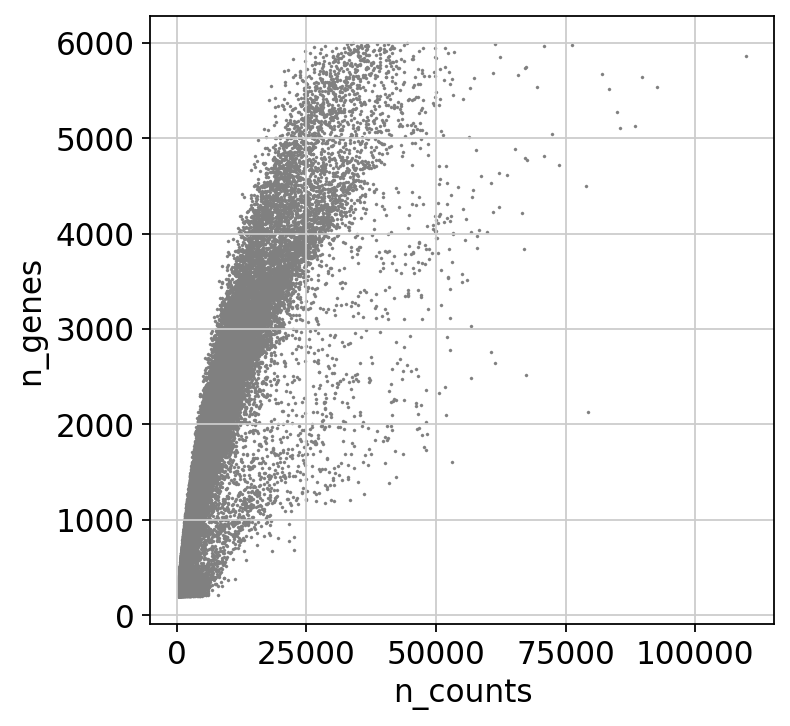

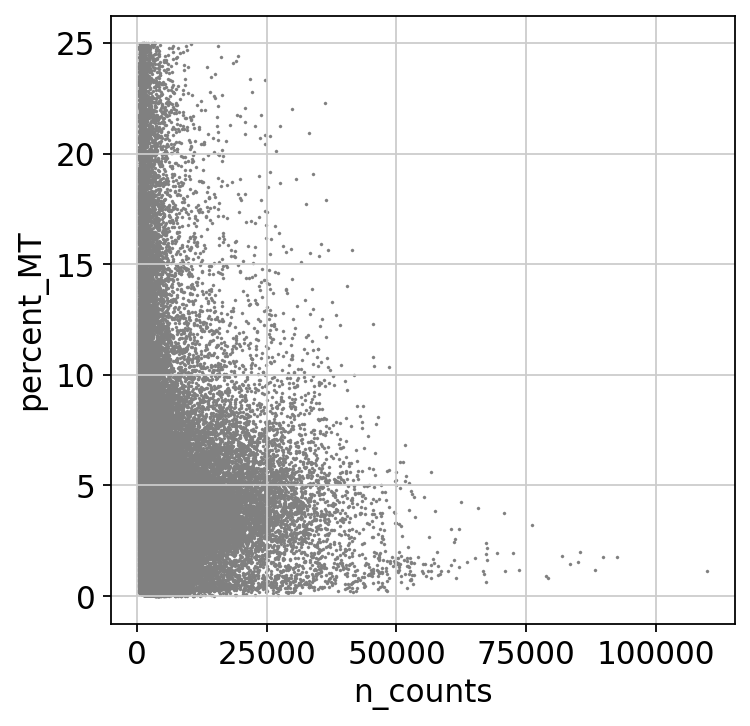

In [15]:
rsc.pp.plt_scatter(cudata,"n_counts","n_genes")
rsc.pp.plt_scatter(cudata,"n_counts","percent_MT")

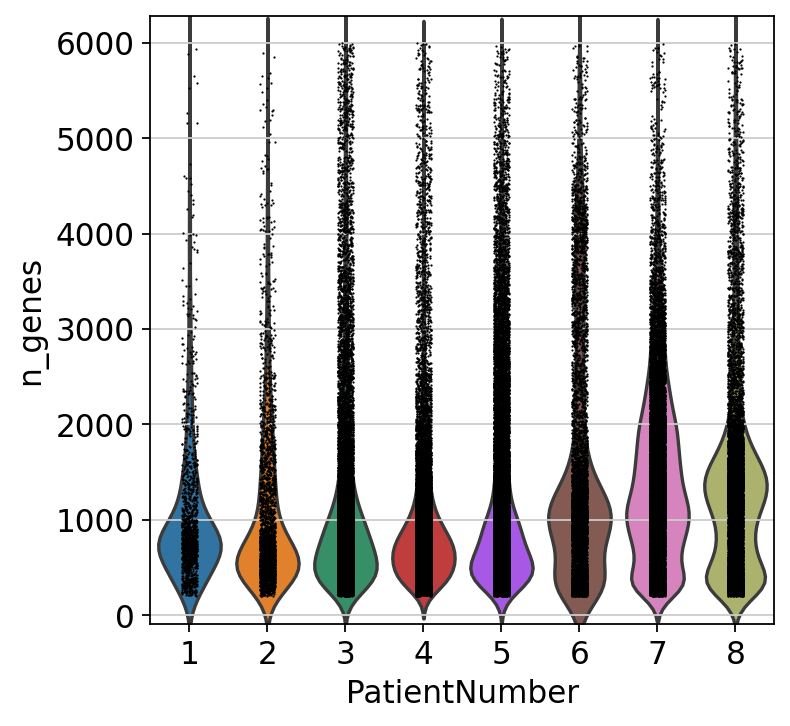

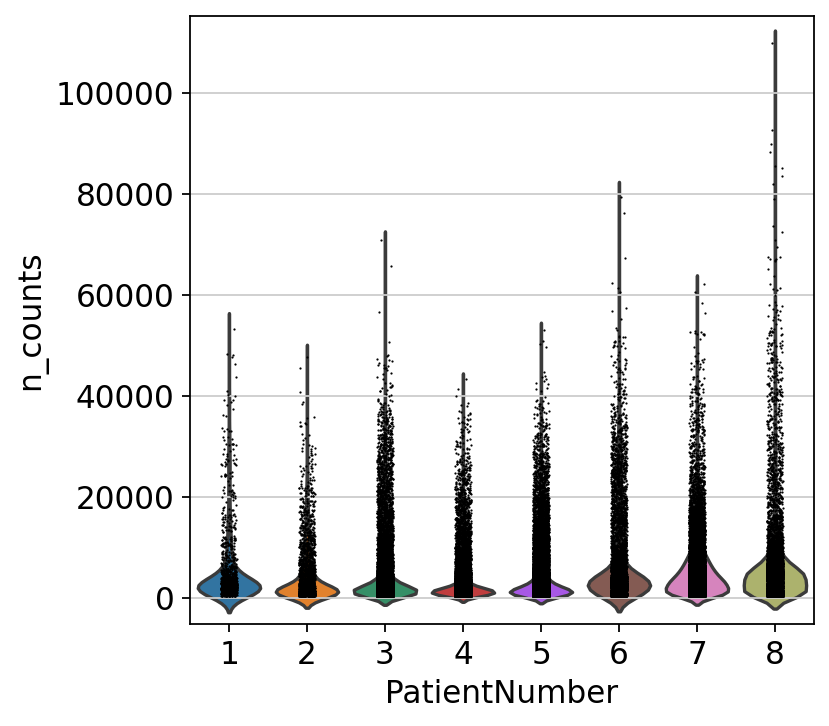

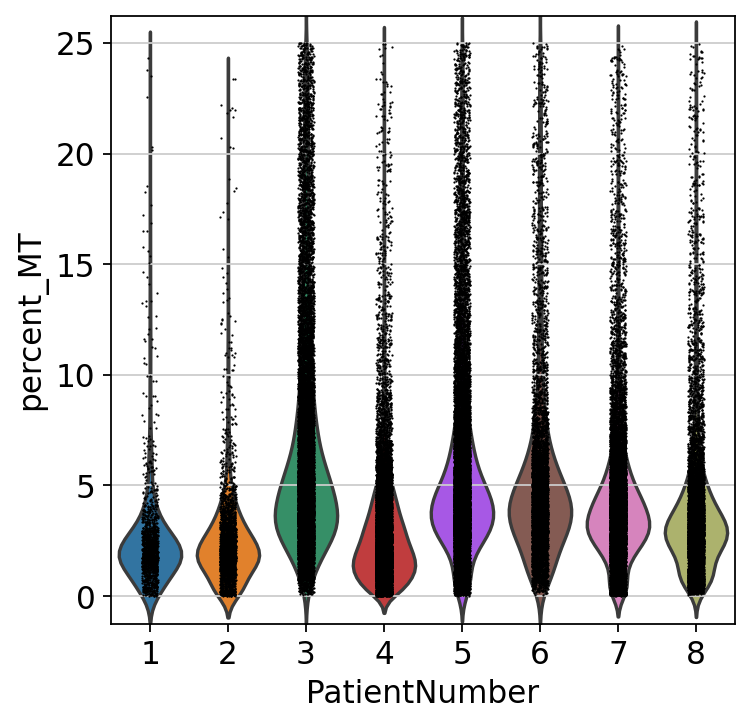

In [16]:
rsc.pp.plt_violin(cudata,key="n_genes",groupby="PatientNumber")
rsc.pp.plt_violin(cudata,key="n_counts",groupby="PatientNumber")
rsc.pp.plt_violin(cudata,key="percent_MT",groupby="PatientNumber")

We store the raw expression counts in the `.layer["counts"]`

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [17]:
%%time
cudata = cudata[cudata.obs["n_genes"] < 5000]
cudata.shape

CPU times: user 3.76 ms, sys: 7.72 ms, total: 11.5 ms
Wall time: 11.1 ms


(92666, 33694)

In [18]:
%%time
cudata = cudata[cudata.obs["percent_MT"] < 20]
cudata.shape

CPU times: user 5.1 ms, sys: 11.7 ms, total: 16.8 ms
Wall time: 16.4 ms


(91180, 33694)

n_samplesWe also filter out genes that are expressed in less than 3 cells.

In [19]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 8034 genes based on n_cells
CPU times: user 63.8 ms, sys: 32.1 ms, total: 95.9 ms
Wall time: 95.6 ms


In [20]:
cudata.layers["counts"] = cudata.X.copy()

In [21]:
cudata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [22]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 411 µs, sys: 432 µs, total: 843 µs
Wall time: 643 µs


Next, we log transform the count matrix.

In [23]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 8.95 ms, sys: 1.07 ms, total: 10 ms
Wall time: 9.82 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [24]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="seurat_v3",batch_key= "PatientNumber",layer = "counts")

CPU times: user 925 ms, sys: 1.95 s, total: 2.87 s
Wall time: 449 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [25]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 151 ms, sys: 125 ms, total: 276 ms
Wall time: 275 ms


Now we restrict our cunndata object to the highly variable genes.

In [26]:
%%time
cudata = cudata[:,cudata.var["highly_variable"]==True]

CPU times: user 99.4 ms, sys: 59.7 ms, total: 159 ms
Wall time: 159 ms


In [27]:
cudata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [28]:
%%time
rsc.pp.regress_out(cudata,keys=["n_counts", "percent_MT"])

CPU times: user 887 ms, sys: 805 ms, total: 1.69 s
Wall time: 1.69 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [29]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 50.1 ms, sys: 5 ms, total: 55.1 ms
Wall time: 54.3 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [30]:
%%time
rsc.pp.pca(cudata, n_comps = 100)

CPU times: user 711 ms, sys: 72.2 ms, total: 783 ms
Wall time: 782 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

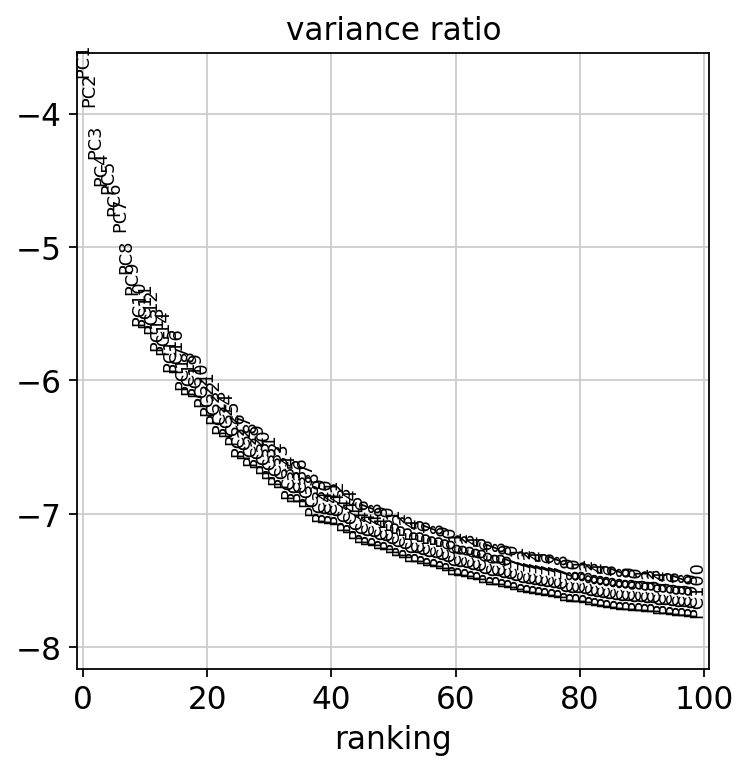

In [31]:
sc.pl.pca_variance_ratio(cudata, log=True,n_pcs=100)

Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [32]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 230 ms, sys: 154 ms, total: 384 ms
Wall time: 383 ms


In [33]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 6.103384017944336


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [34]:
%%time
rsc.tl.harmony_integrate(adata,key="PatientNumber")

2023-01-18 21:10:04,114 - harmonypy_gpu - INFO - Computing initial centroids with cuml.KMeans...
2023-01-18 21:10:04,253 - harmonypy_gpu - INFO - cuml.KMeans initialization complete.
2023-01-18 21:10:04,333 - harmonypy_gpu - INFO - Iteration 1 of 10
2023-01-18 21:10:07,108 - harmonypy_gpu - INFO - Iteration 2 of 10
2023-01-18 21:10:09,877 - harmonypy_gpu - INFO - Iteration 3 of 10
2023-01-18 21:10:12,628 - harmonypy_gpu - INFO - Iteration 4 of 10
2023-01-18 21:10:15,366 - harmonypy_gpu - INFO - Iteration 5 of 10
2023-01-18 21:10:17,097 - harmonypy_gpu - INFO - Iteration 6 of 10
2023-01-18 21:10:19,031 - harmonypy_gpu - INFO - Iteration 7 of 10
2023-01-18 21:10:20,662 - harmonypy_gpu - INFO - Iteration 8 of 10
2023-01-18 21:10:22,498 - harmonypy_gpu - INFO - Iteration 9 of 10
2023-01-18 21:10:24,028 - harmonypy_gpu - INFO - Iteration 10 of 10
2023-01-18 21:10:25,766 - harmonypy_gpu - INFO - Stopped before convergence


CPU times: user 11.5 s, sys: 10.2 s, total: 21.7 s
Wall time: 21.7 s


In [35]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 4.58 s, sys: 59.6 ms, total: 4.64 s
Wall time: 4.63 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [36]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 368 ms, sys: 5.73 ms, total: 374 ms
Wall time: 373 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.
Leiden clustering using Rapids has not been implemented in scanpy. You can also use `scanpy_gpu_funcs` implementation of the Leiden algorithm.

In [37]:
%%time
rsc.tl.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 236 ms, sys: 331 ms, total: 567 ms
Wall time: 567 ms


In [38]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 92.3 ms, sys: 12.6 ms, total: 105 ms
Wall time: 104 ms


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


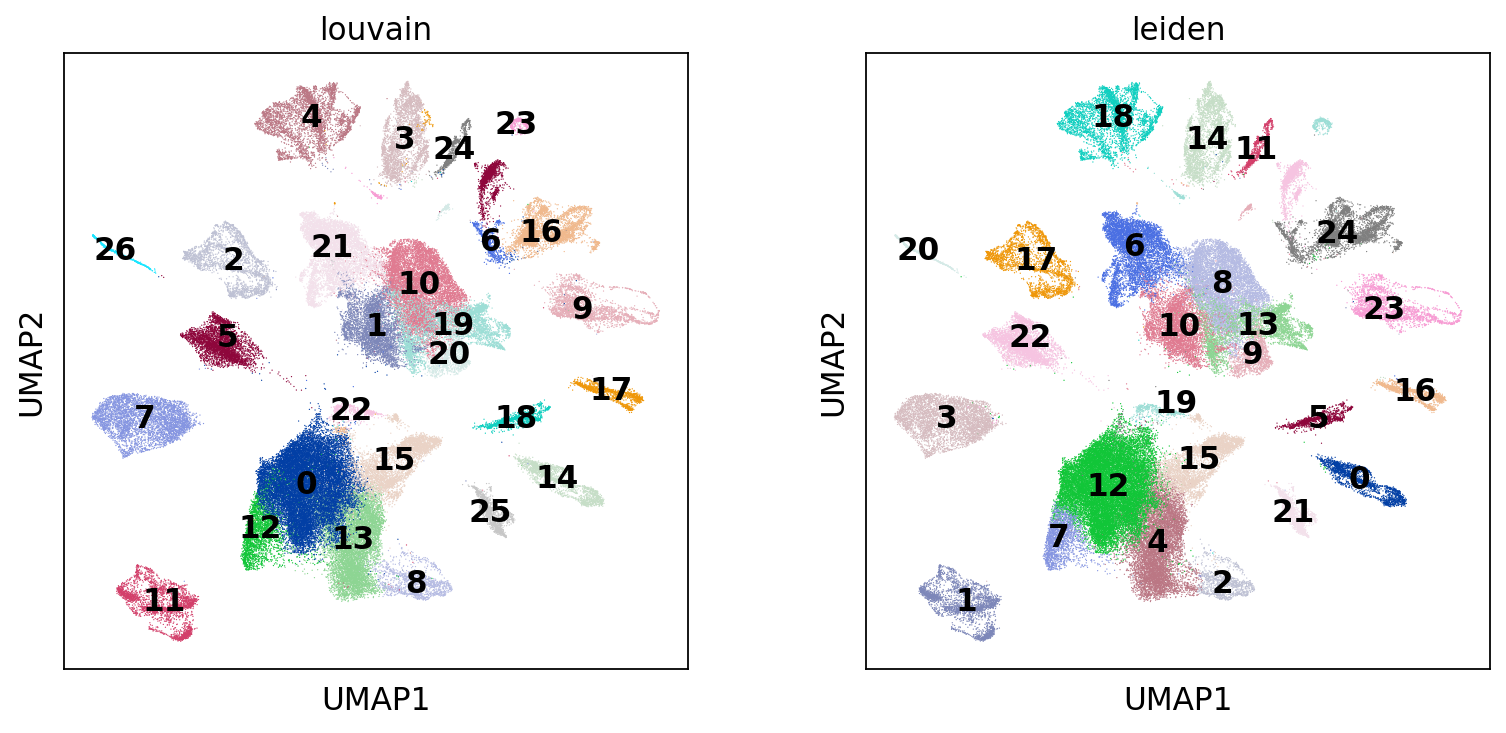

CPU times: user 595 ms, sys: 136 ms, total: 731 ms
Wall time: 571 ms


In [39]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


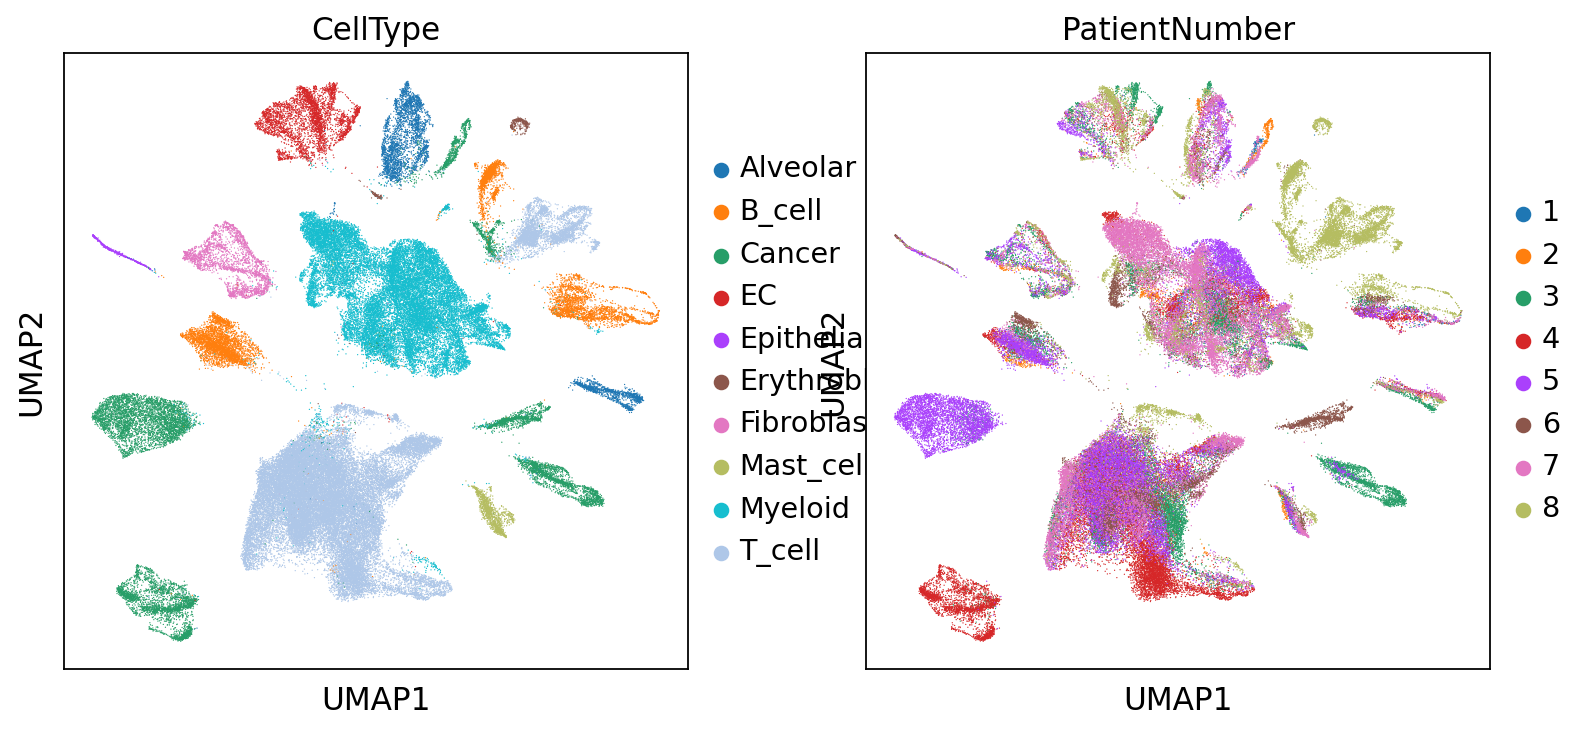

In [40]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

We also caluclate the embedding density in the UMAP using cuML

In [41]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 851 ms, sys: 81.4 ms, total: 932 ms
Wall time: 931 ms


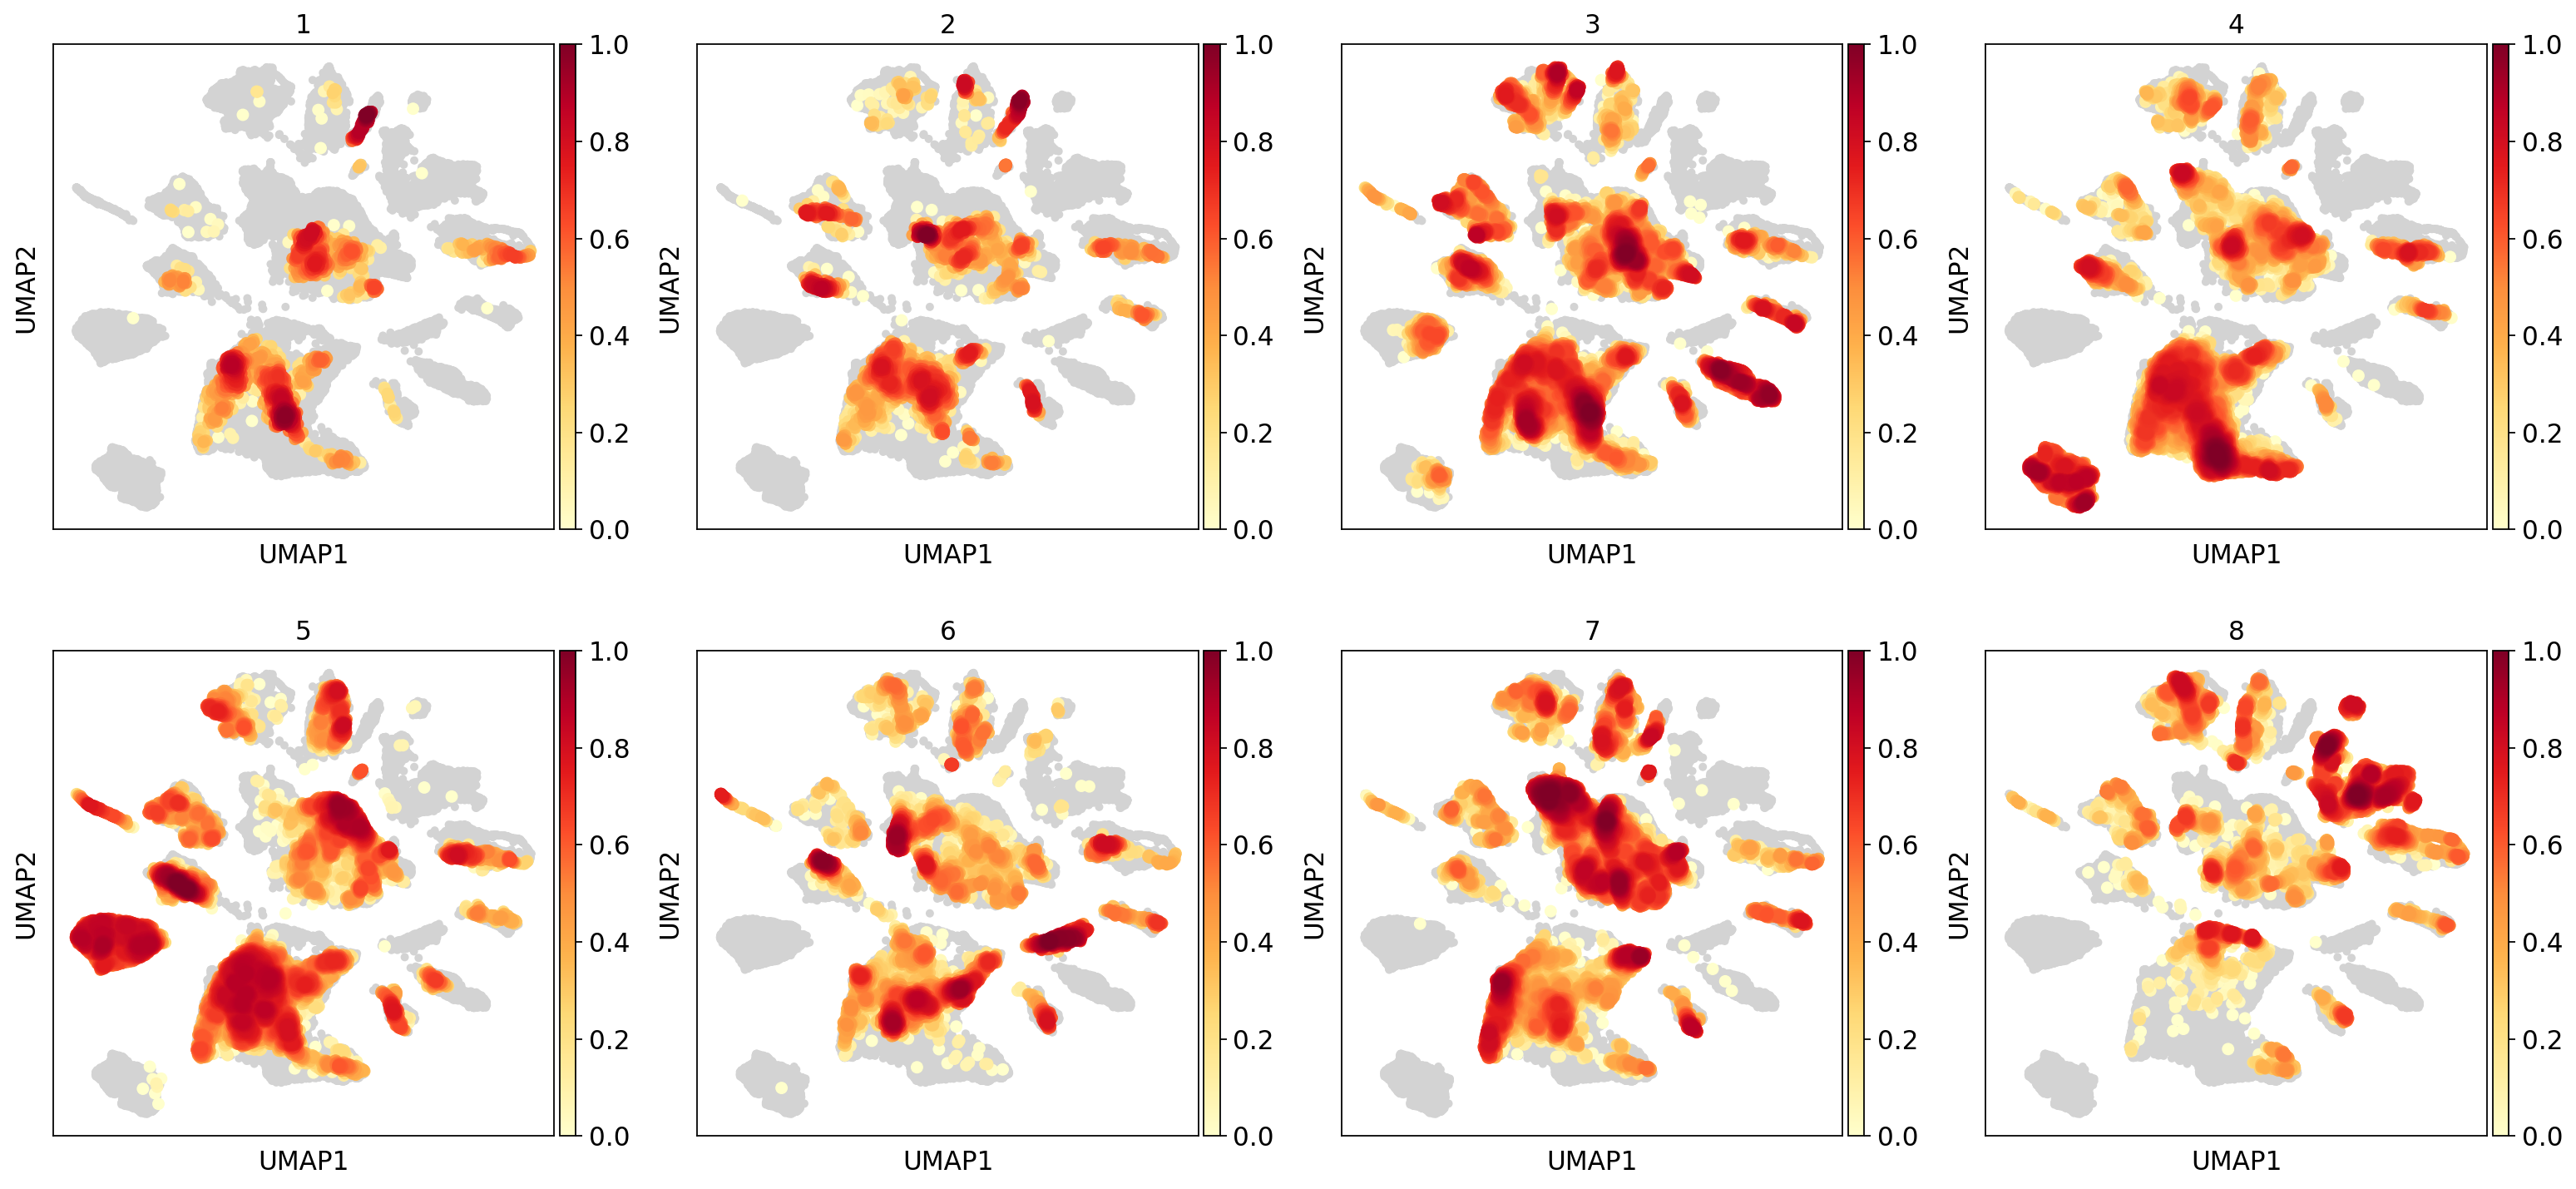

In [42]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [43]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [21:10:36.327216] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.39 s, sys: 14.5 ms, total: 1.41 s
Wall time: 1.4 s


In [44]:
rsc.tl.kmeans(adata, n_clusters=8)

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


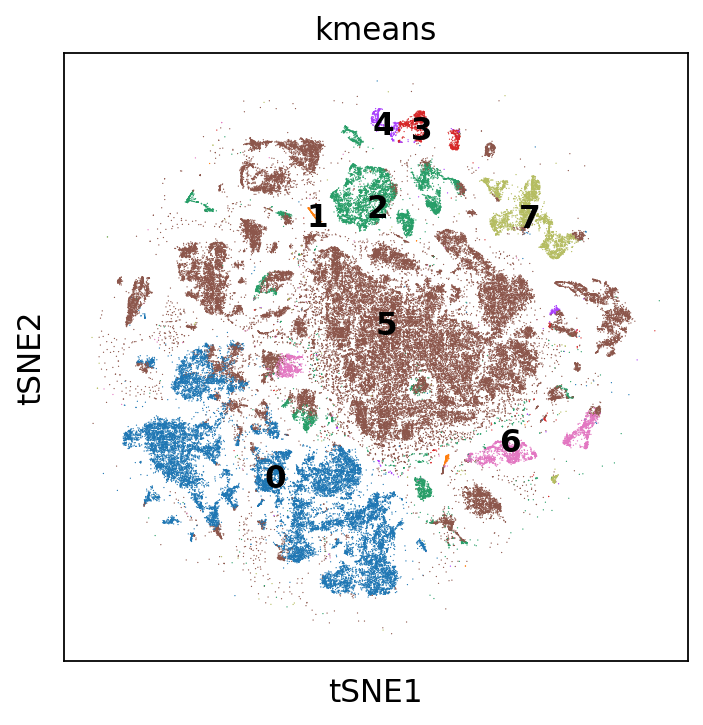

CPU times: user 387 ms, sys: 130 ms, total: 516 ms
Wall time: 321 ms


In [45]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


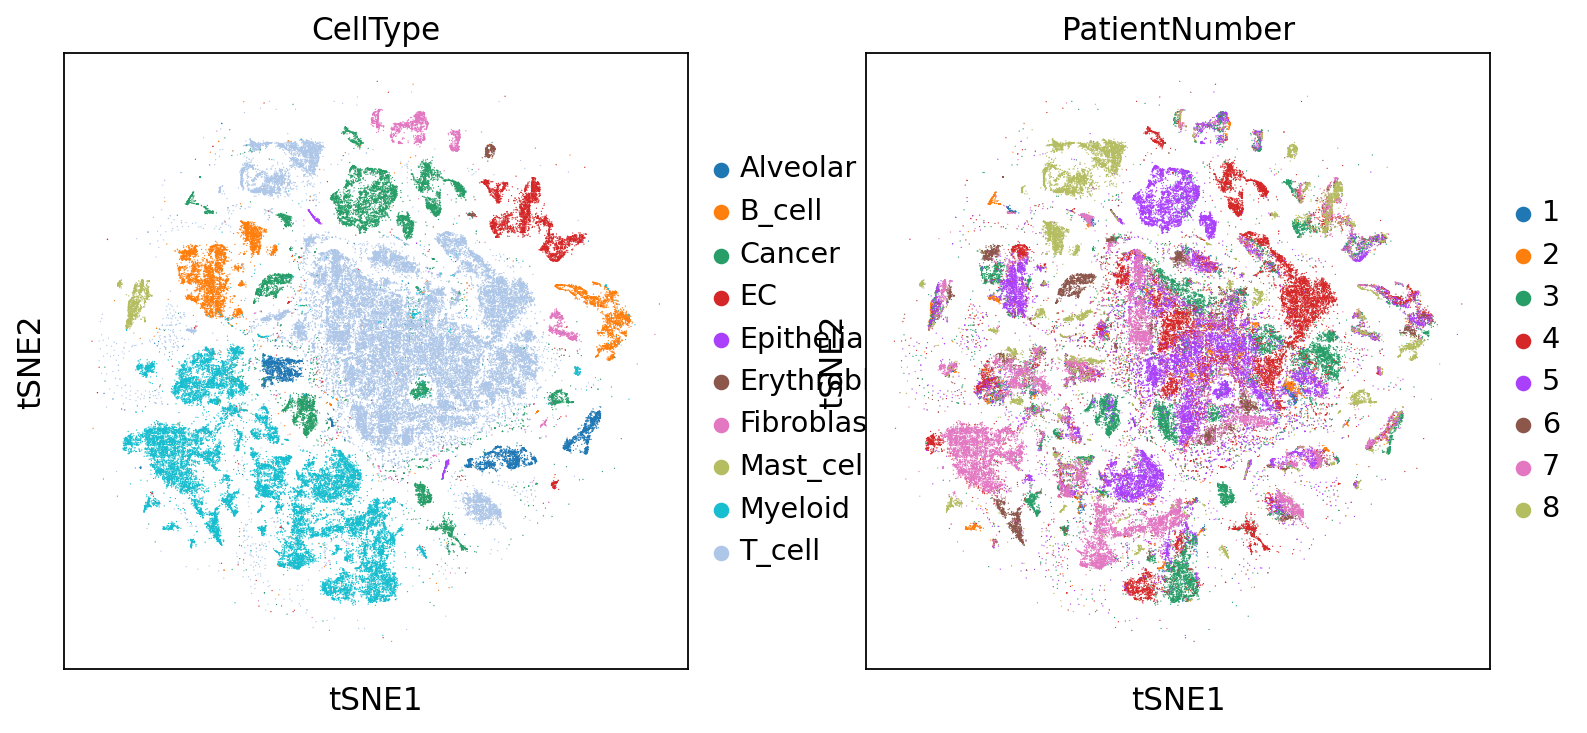

In [46]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [47]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.89 s, sys: 867 ms, total: 3.75 s
Wall time: 3.75 s


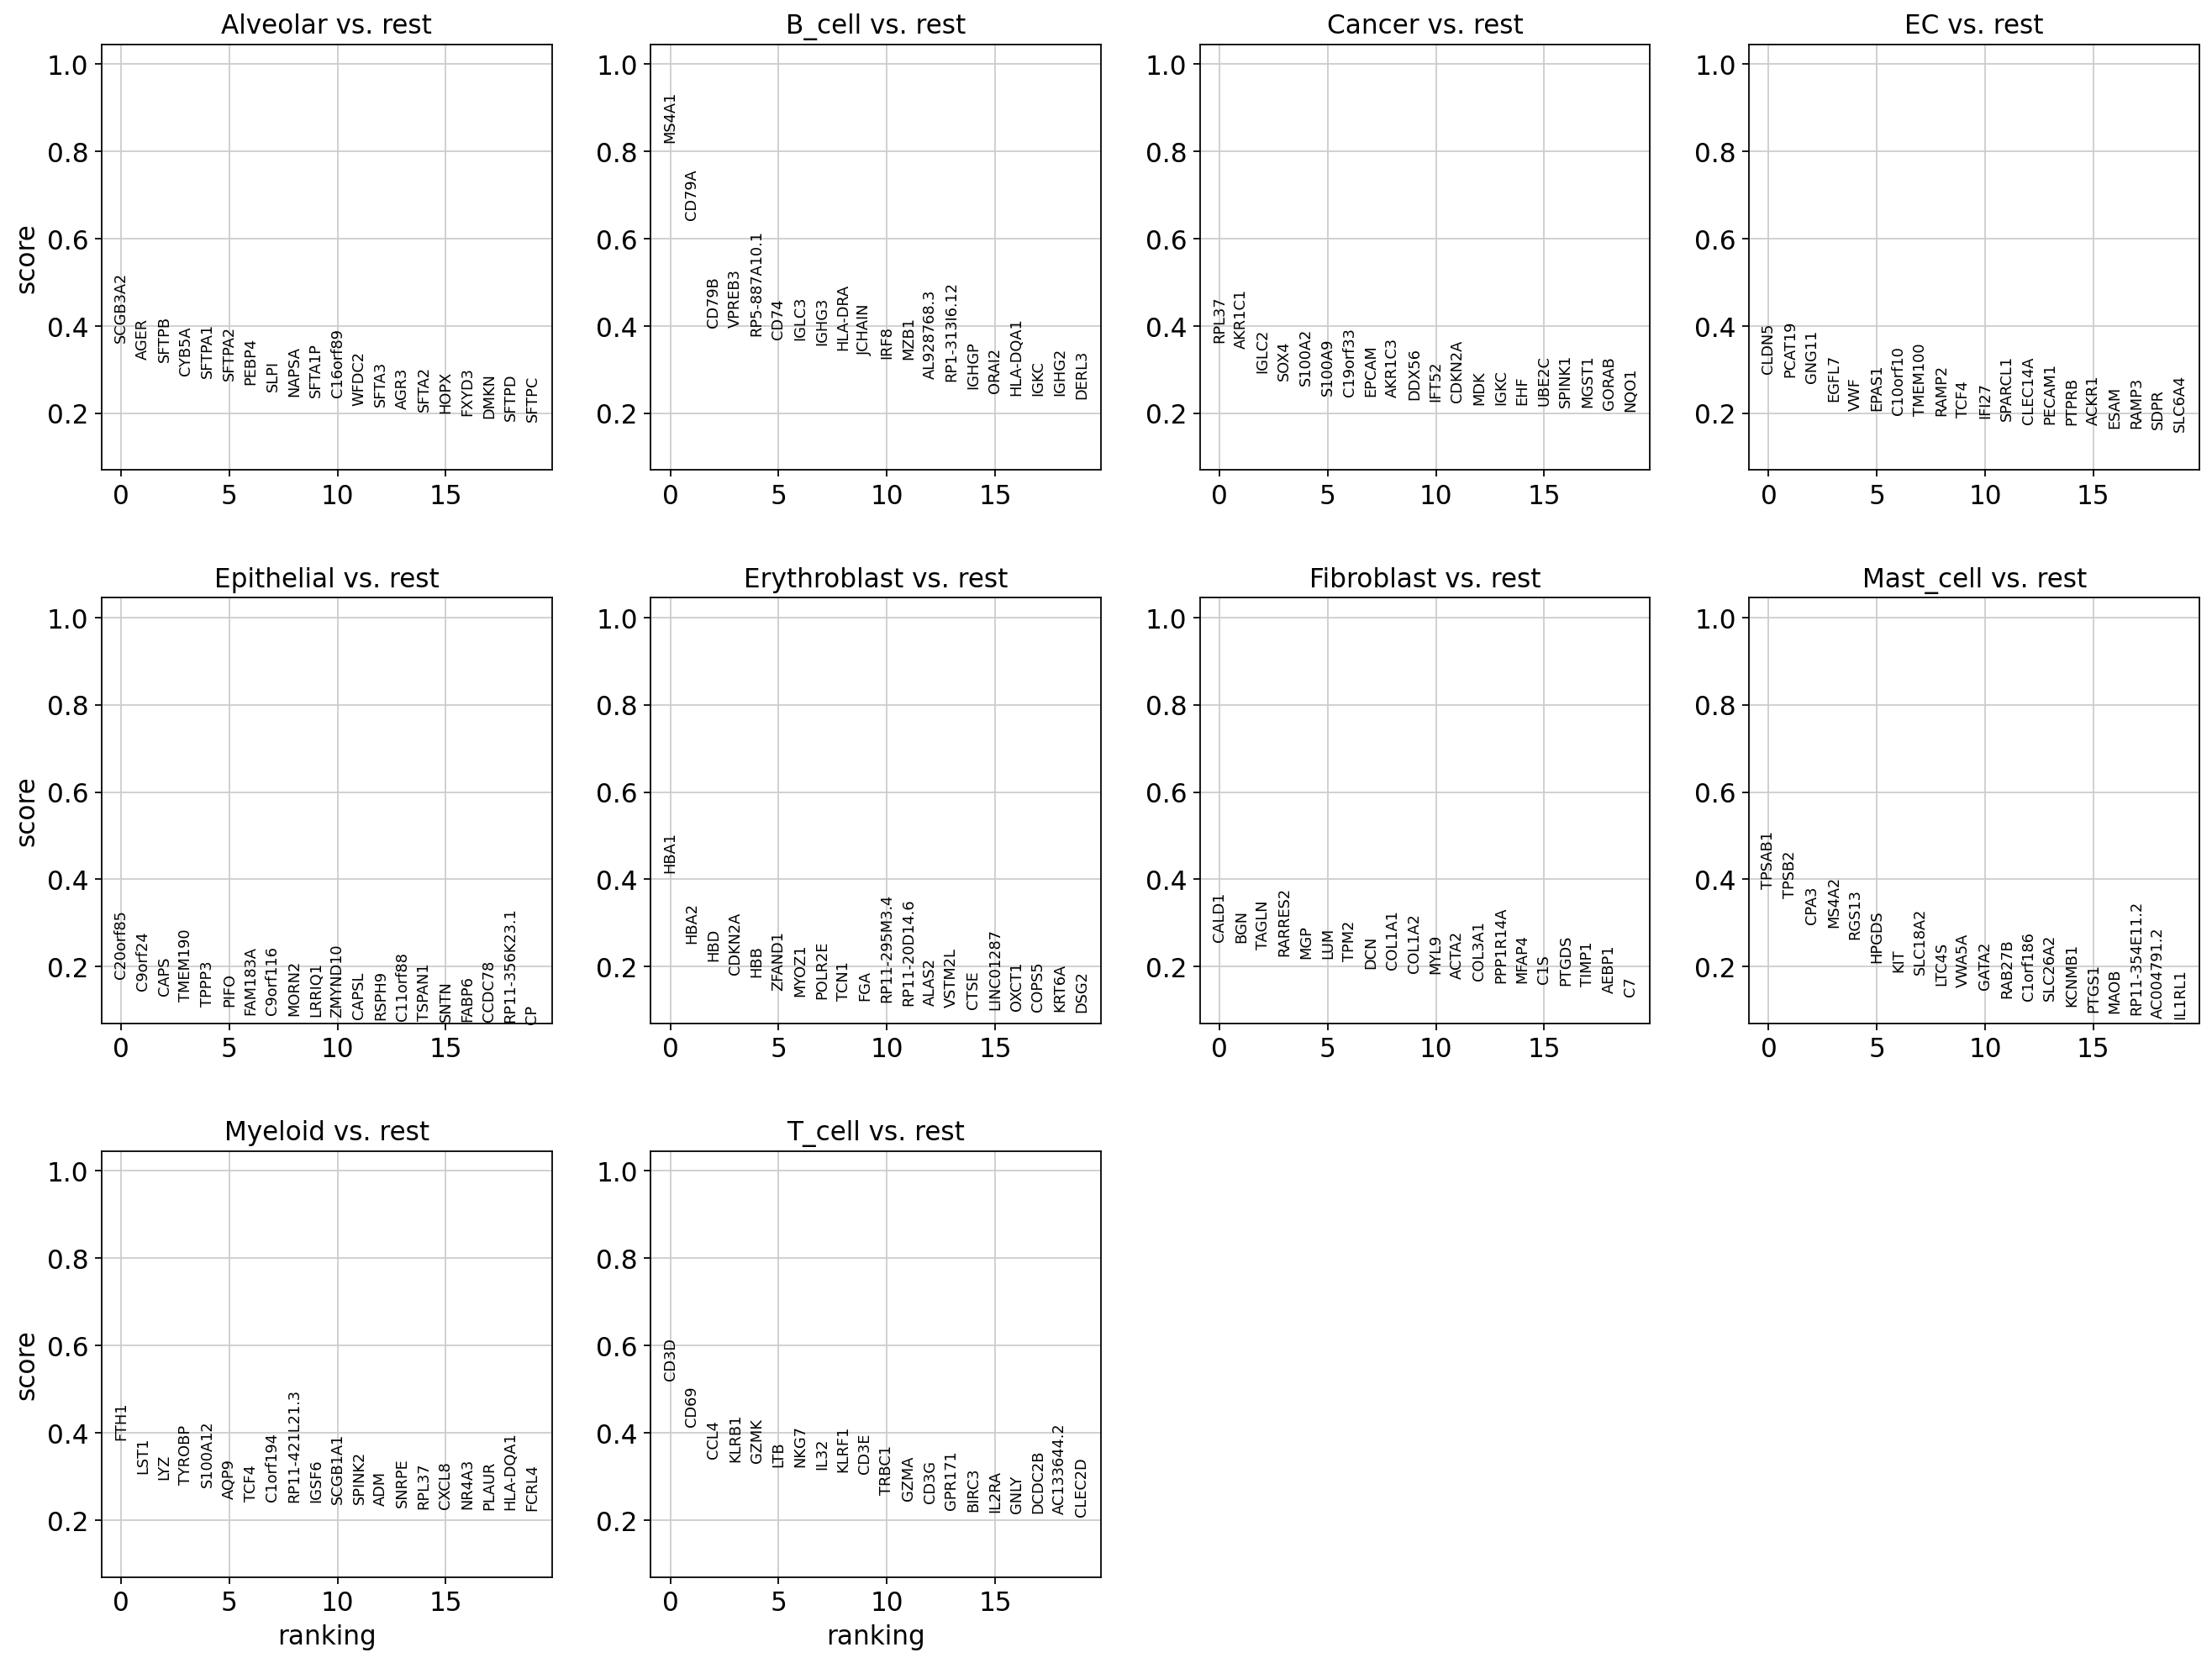

CPU times: user 808 ms, sys: 144 ms, total: 952 ms
Wall time: 789 ms


In [48]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [49]:
post_time = time.time()

In [50]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 39.34262204170227


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [51]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

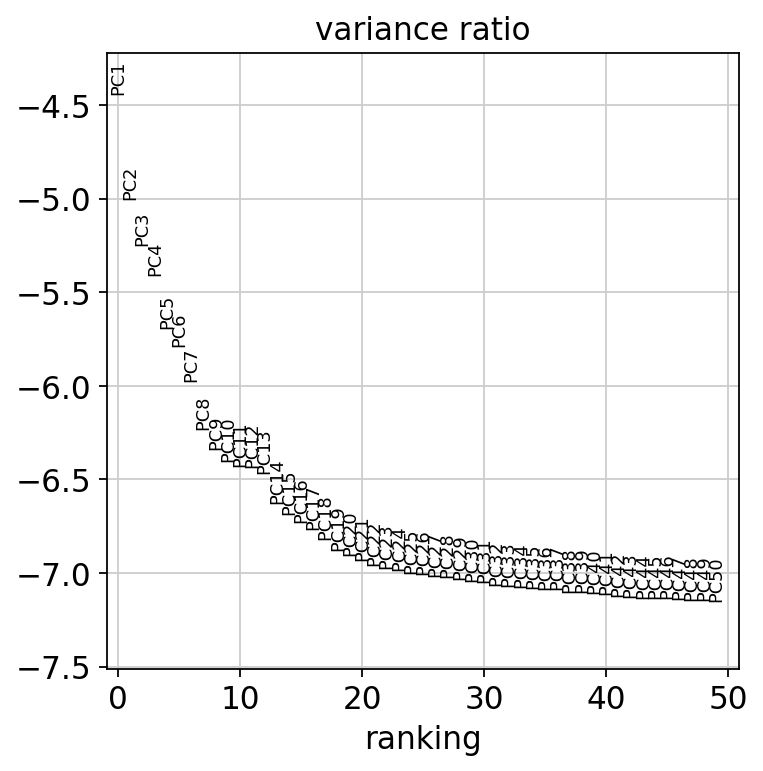

CPU times: user 812 ms, sys: 424 ms, total: 1.24 s
Wall time: 1.08 s


In [52]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [53]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20, method='rapids')
sc.tl.umap(tdata, method='rapids')
rsc.tl.leiden(tdata)

CPU times: user 719 ms, sys: 23.9 ms, total: 743 ms
Wall time: 731 ms


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


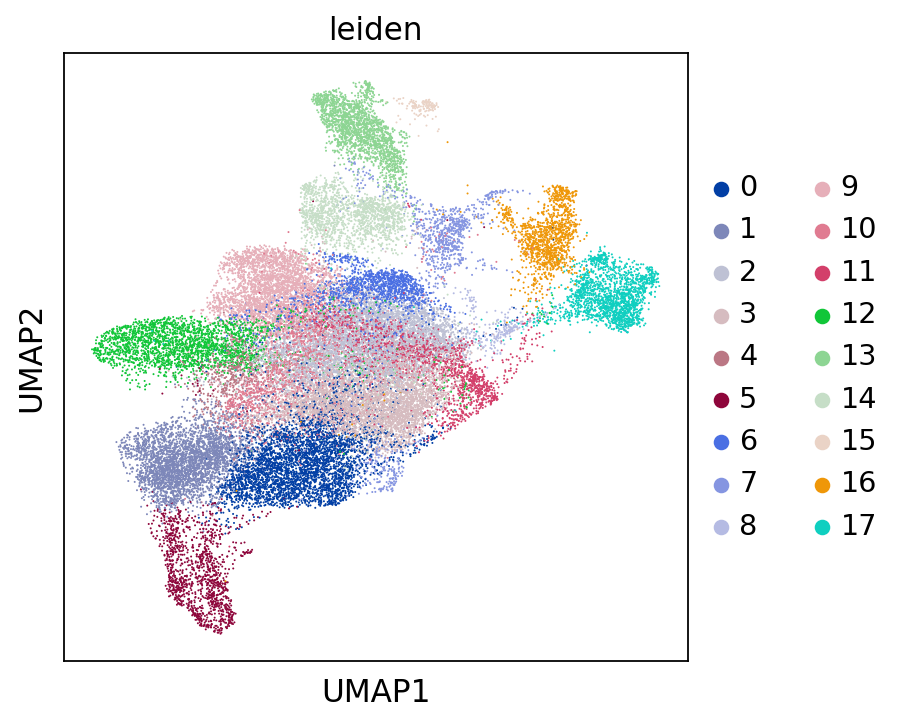

In [54]:
sc.pl.umap(tdata, color=["leiden"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [55]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 307 ms, sys: 604 ms, total: 911 ms
Wall time: 101 ms


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


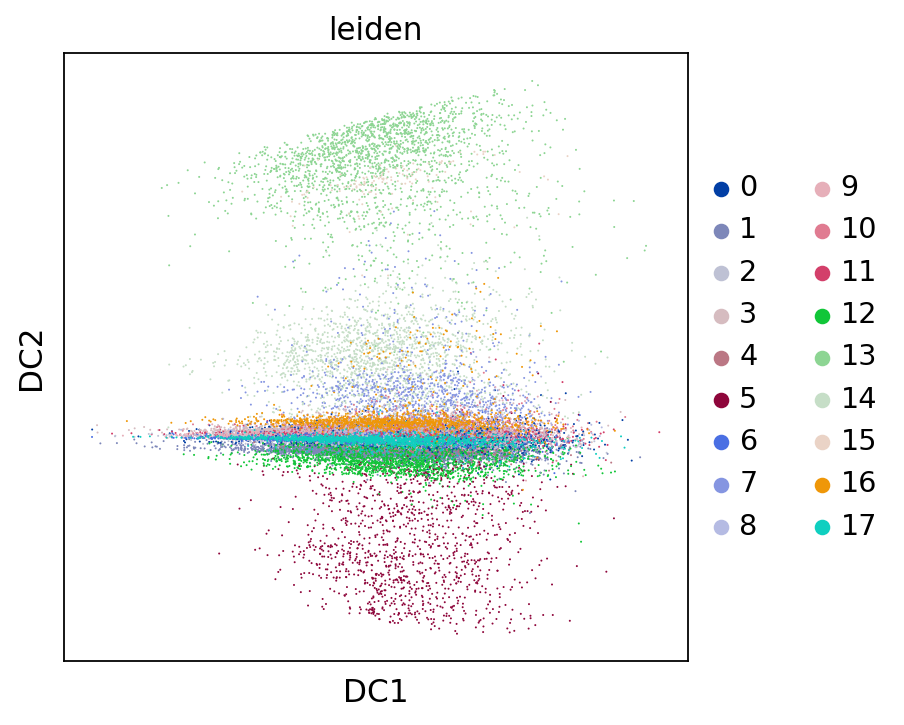

In [56]:
sc.pl.diffmap(tdata, color='leiden')

In [57]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 232 ms, sys: 4.31 ms, total: 236 ms
Wall time: 236 ms


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


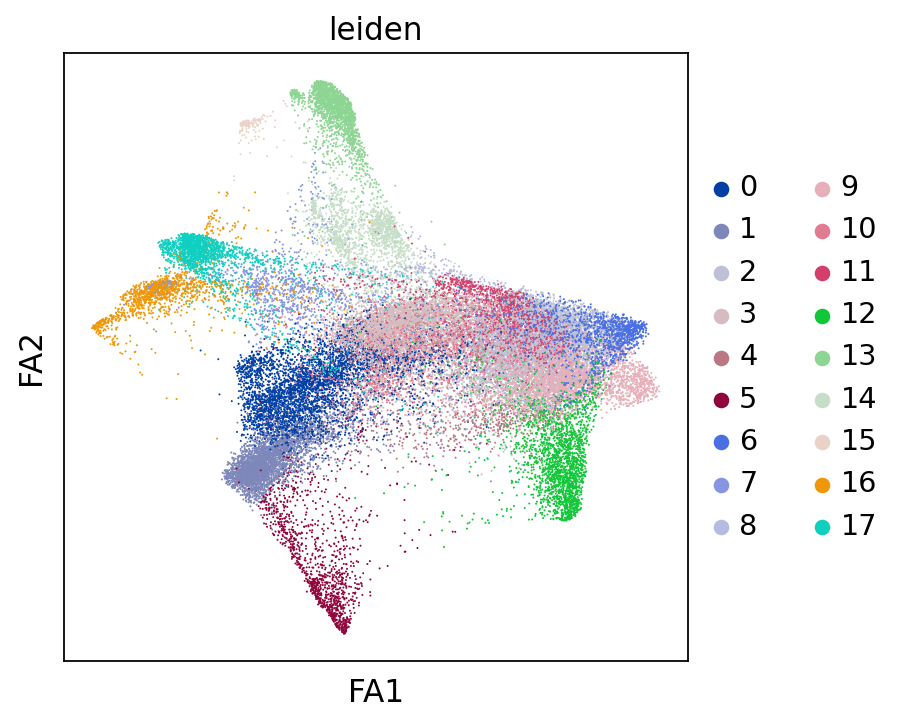

In [58]:
sc.pl.draw_graph(tdata, color='leiden')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [59]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 48.798253774642944
